# Descriptive Analysis (Appendix-Style) — Daily Profiles by Portal

Replicates the Group 9 appendix style daily profiles:
- Aggregate within each minute by `PORTAL`: FLOW=sum over DP_ID, SPEED=mean over DP_ID.
- Focus morning window 04:00–10:00 (training period).
- For each `PORTAL`, compute across-day minute-of-day profiles: mean, p25, median, p75.
- Optional: weekday vs weekend comparison.


In [7]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

DATA_CSV = os.path.join('Dataset','dataset_for_traffic_project_assignment','training_dataset.csv')
SEP = ';'
SAVE_FIGS = False
FIG_DIR = 'figures_appendix'
if SAVE_FIGS:
    os.makedirs(FIG_DIR, exist_ok=True)

MORNING_START = time(4, 0)
MORNING_END   = time(10, 0)

def savefig(name):
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, name), bbox_inches='tight', dpi=150)

def minute_to_label(m):
    h, mm = divmod(int(m), 60)
    return f'{h:02d}:{mm:02d}'

pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 120)


## 1. Load and parse time

In [8]:

usecols = ['DP_ID','PORTAL','Date','Time','SPEED_MS_AVG','FLOW']
df = pd.read_csv(DATA_CSV, sep=SEP, low_memory=False, usecols=usecols)
print('Raw shape:', df.shape)

df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d', errors='coerce')
dt = pd.to_datetime(df['Date'].dt.strftime('%Y%m%d') + ' ' + df['Time'].astype(str),
                    format='%Y%m%d %H:%M:%S', errors='coerce')
df['datetime'] = dt
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['minute_of_day'] = df['hour']*60 + df['minute']
df['weekday'] = df['datetime'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

mask_time = (df['datetime'].dt.time >= MORNING_START) & (df['datetime'].dt.time < MORNING_END)
df = df[mask_time].copy()
print('After morning window filter:', df.shape)

print('Missing FLOW:', df['FLOW'].isna().sum(), '| Missing SPEED_MS_AVG:', df['SPEED_MS_AVG'].isna().sum())
df.head()


Raw shape: (1921967, 6)
After morning window filter: (1916118, 12)
Missing FLOW: 62 | Missing SPEED_MS_AVG: 0


,DP_ID,PORTAL,Date,Time,SPEED_MS_AVG,FLOW,datetime,hour,minute,minute_of_day,weekday,is_weekend
0,543,"E4S 56,780",2021-06-01,04:00:00,19.34,10.0,2021-06-01 04:00:00,4,0,240,1,0
1,539,"E4S 56,160",2021-06-01,04:00:00,19.64,9.0,2021-06-01 04:00:00,4,0,240,1,0
2,534,"E4S 56,780",2021-06-01,04:00:00,23.36,5.0,2021-06-01 04:00:00,4,0,240,1,0
3,351,"E4S 56,490",2021-06-01,04:00:00,20.14,7.0,2021-06-01 04:00:00,4,0,240,1,0
4,353,"E4S 57,055",2021-06-01,04:00:00,17.70,7.0,2021-06-01 04:00:00,4,0,240,1,0


## 2. Aggregate within portal (per minute)

In [9]:

df['date_only'] = df['datetime'].dt.date
g = (df.groupby(['PORTAL','date_only','minute_of_day'], as_index=False)
       .agg(FLOW_sum=('FLOW','sum'), SPEED_mean=('SPEED_MS_AVG','mean')))
print('Aggregated per-portal-per-minute rows:', g.shape)
g.head()


Aggregated per-portal-per-minute rows: (602336, 5)


,PORTAL,date_only,minute_of_day,FLOW_sum,SPEED_mean
0,"E4S 55,620",2021-06-01,240,29.0,22.110000
1,"E4S 55,620",2021-06-01,241,26.0,23.533333
2,"E4S 55,620",2021-06-01,242,38.0,21.830000
3,"E4S 55,620",2021-06-01,243,34.0,22.736667
4,"E4S 55,620",2021-06-01,244,29.0,23.336667


## 3. Across-day minute-of-day profiles (mean, p25, median, p75)

In [10]:

def summarize_profile(df_portal):
    f = df_portal.groupby('minute_of_day')['FLOW_sum']
    s = df_portal.groupby('minute_of_day')['SPEED_mean']
    prof_flow = f.agg(mean='mean', p25=lambda x: x.quantile(0.25), p50='median', p75=lambda x: x.quantile(0.75))
    prof_speed = s.agg(mean='mean', p25=lambda x: x.quantile(0.25), p50='median', p75=lambda x: x.quantile(0.75))
    prof = pd.concat({'flow': prof_flow, 'speed': prof_speed}, axis=1).reset_index()
    return prof

profiles = {}
for portal, d in g.groupby('PORTAL'):
    profiles[portal] = summarize_profile(d)

print('Number of portals:', len(profiles))
list(profiles.keys())[:10]


Number of portals: 8


['E4S 55,620',
 'E4S 56,160',
 'E4S 56,490',
 'E4S 56,780',
 'E4S 57,055',
 'E4S 57,435',
 'E4S 57,820',
 'E4S 58,140']

## 4. Plot daily profiles for each portal (FLOW & SPEED)

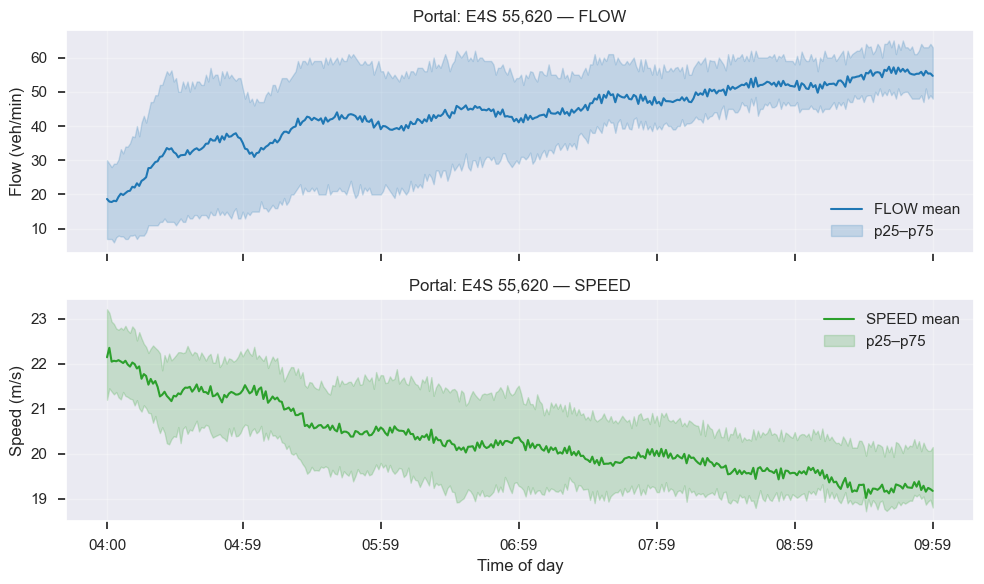

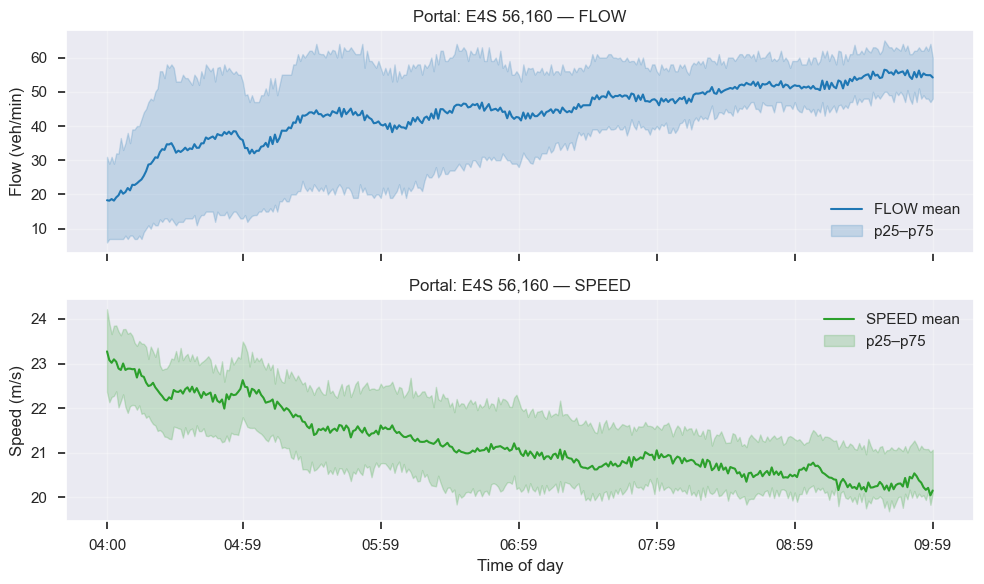

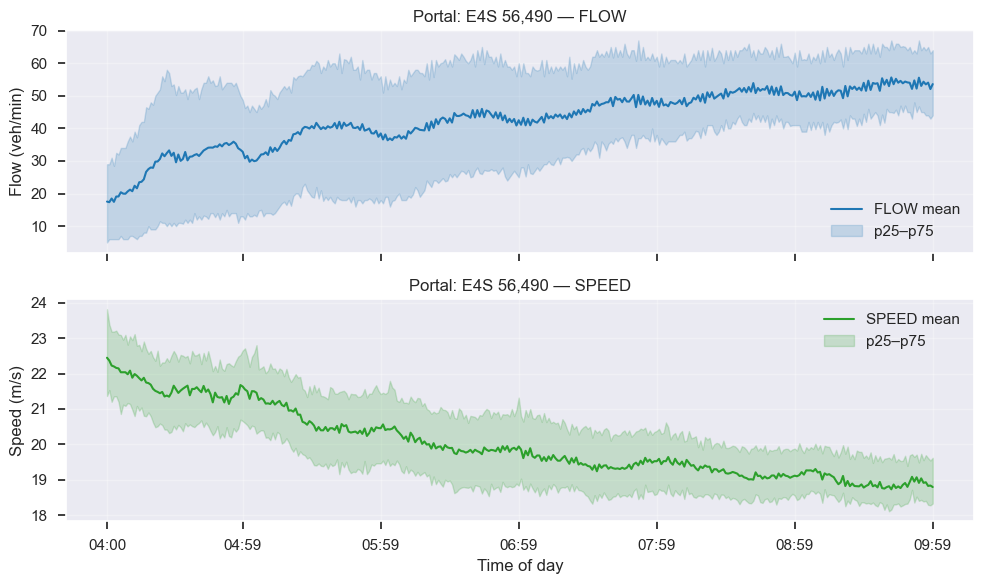

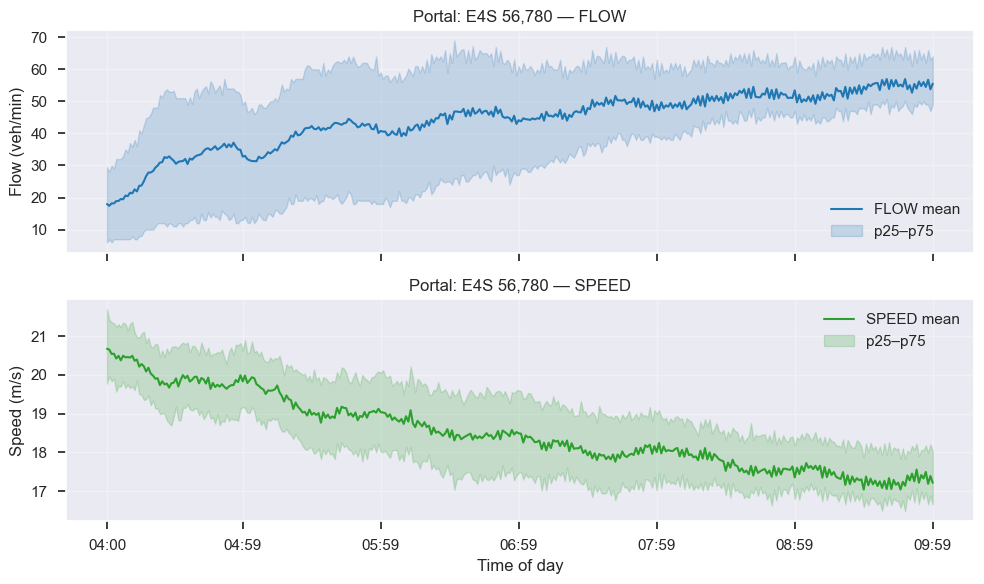

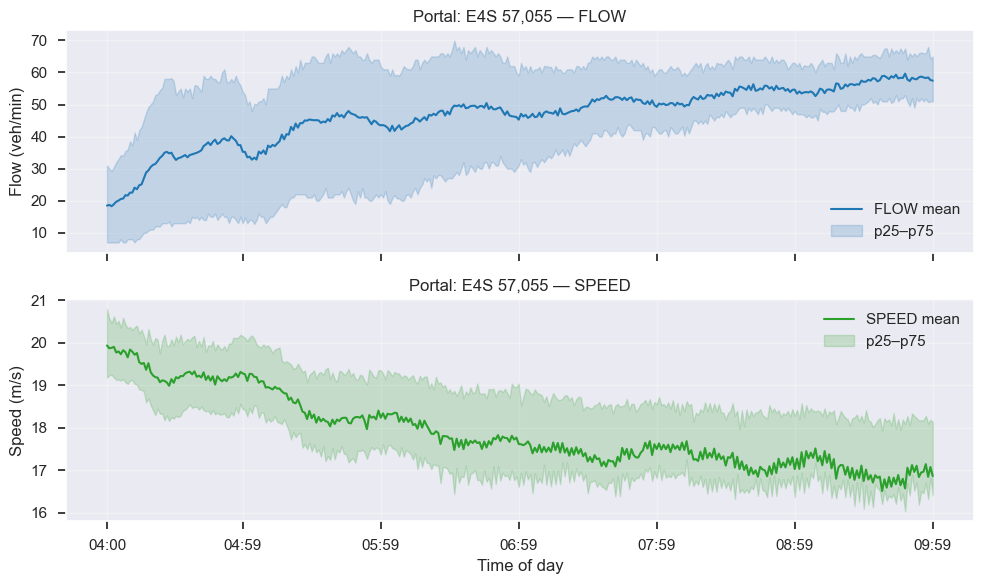

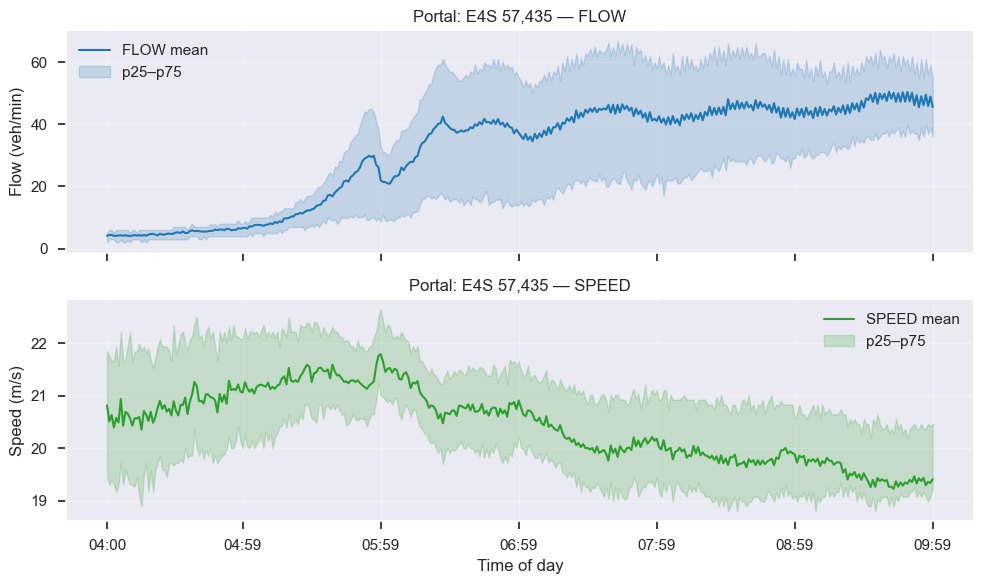

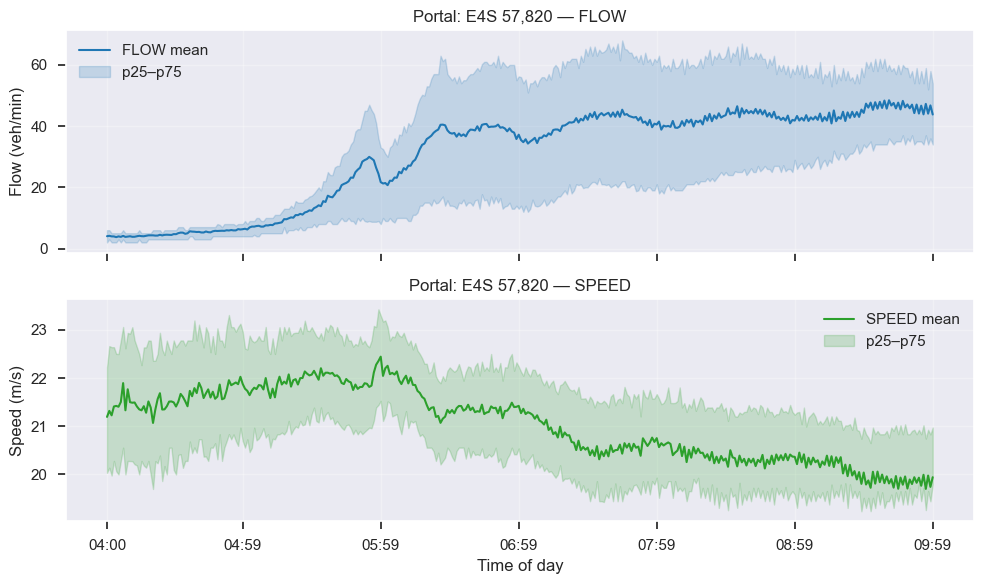

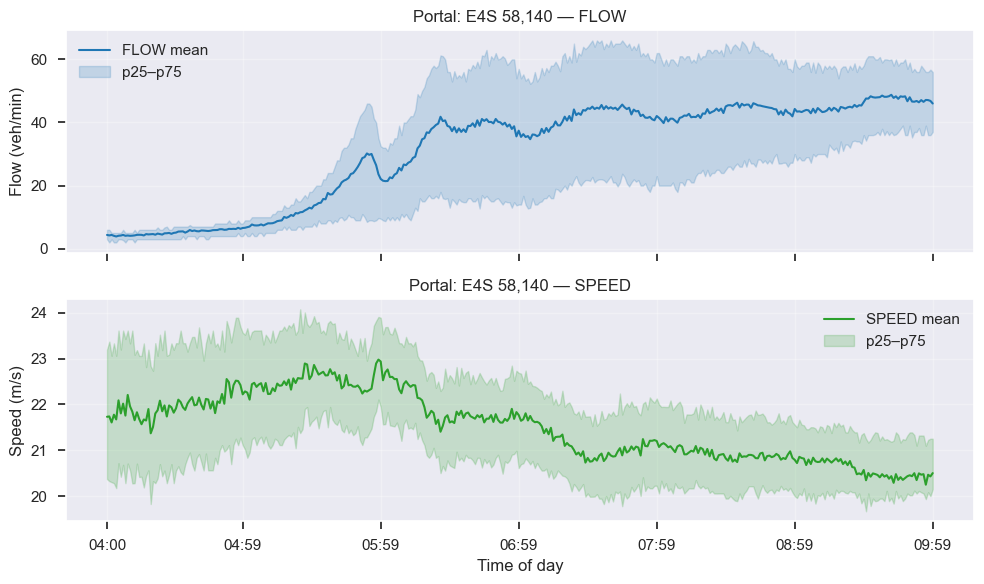

In [11]:

def plot_profile(portal, prof):
    x = prof['minute_of_day'].values
    xticks = np.linspace(x.min(), x.max(), 7, dtype=int)
    xtick_labels = [minute_to_label(v) for v in xticks]

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axes[0].plot(x, prof['flow']['mean'], color='tab:blue', label='FLOW mean')
    axes[0].fill_between(x, prof['flow']['p25'], prof['flow']['p75'], color='tab:blue', alpha=0.2, label='p25–p75')
    axes[0].set_ylabel('Flow (veh/min)')
    axes[0].set_title(f'Portal: {portal} — FLOW')
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    axes[1].plot(x, prof['speed']['mean'], color='tab:green', label='SPEED mean')
    axes[1].fill_between(x, prof['speed']['p25'], prof['speed']['p75'], color='tab:green', alpha=0.2, label='p25–p75')
    axes[1].set_ylabel('Speed (m/s)')
    axes[1].set_title(f'Portal: {portal} — SPEED')
    axes[1].set_xlabel('Time of day')
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    plt.xticks(xticks, xtick_labels, rotation=0)
    plt.tight_layout()
    savefig(f'portal_{portal.replace(" ","_")}_daily_profile.png')
    plt.show()

for portal, prof in profiles.items():
    plot_profile(portal, prof)


## 5. Weekday vs Weekend (optional)

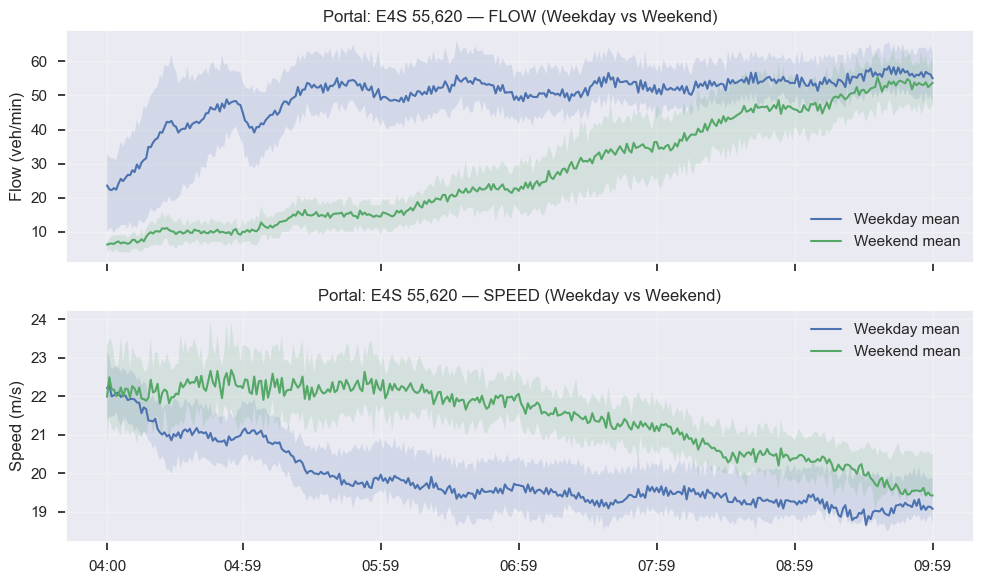

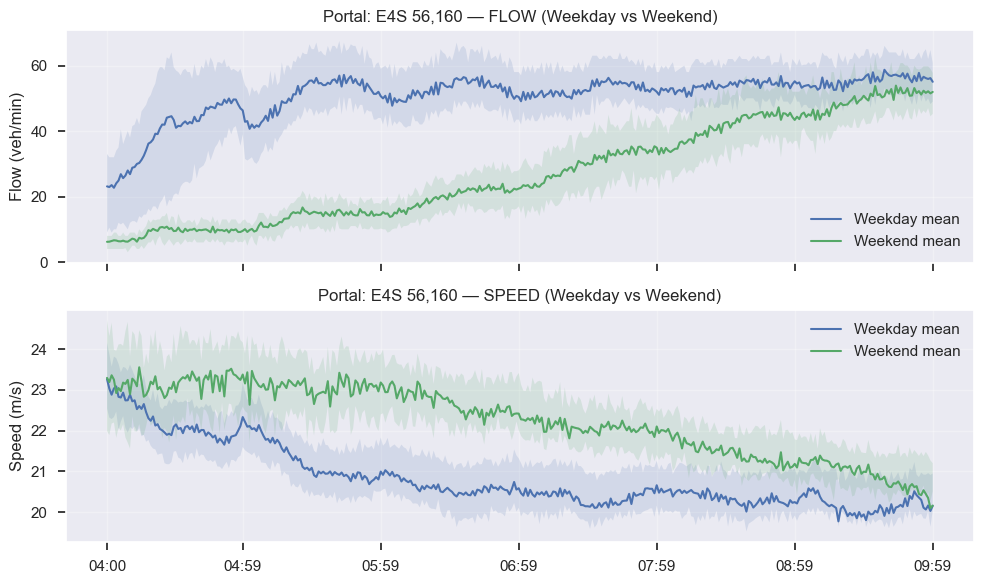

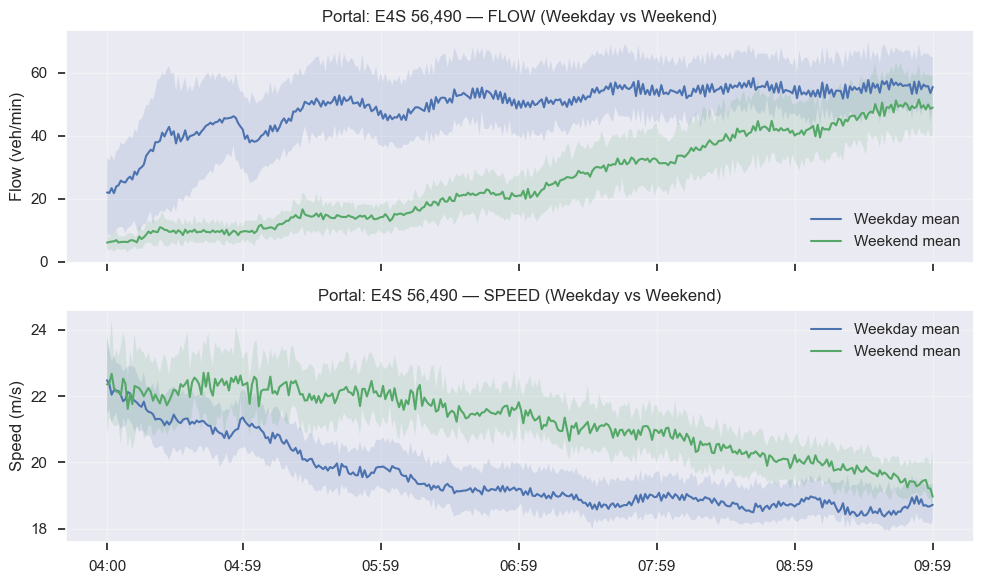

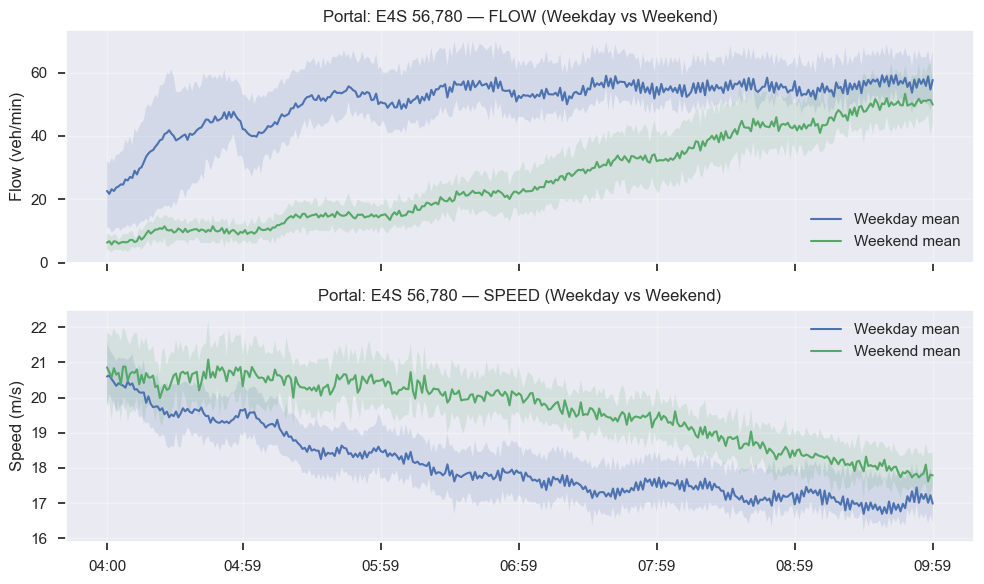

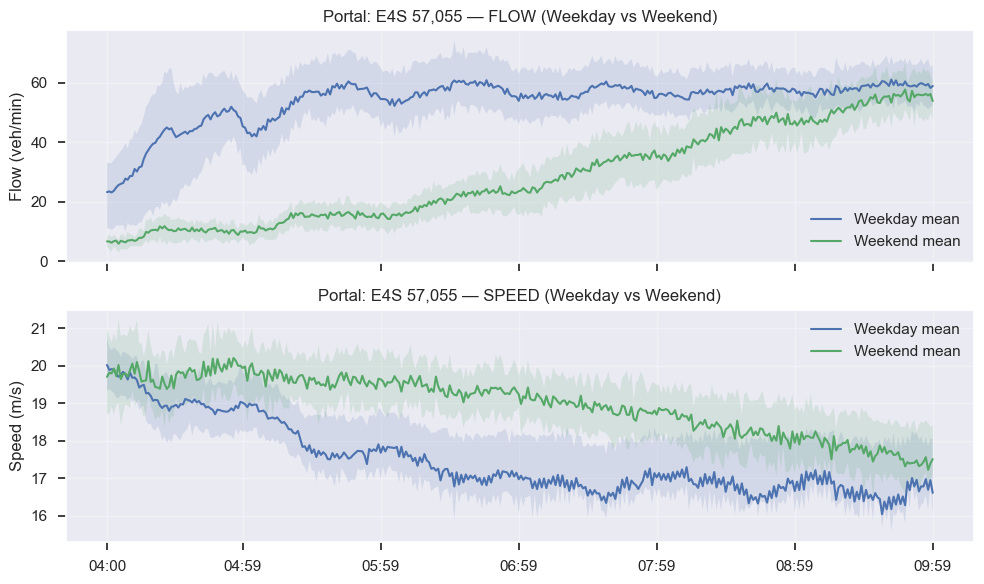

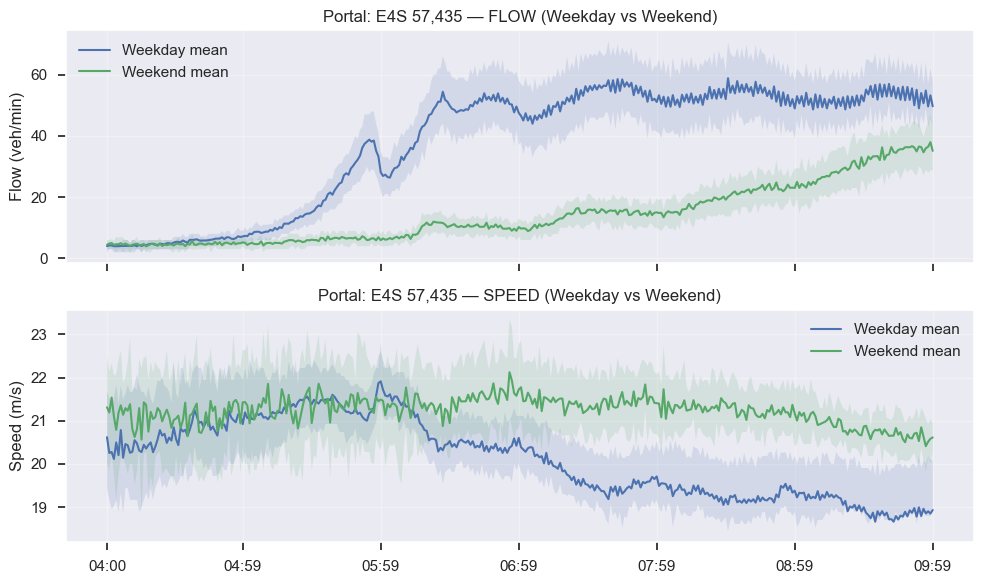

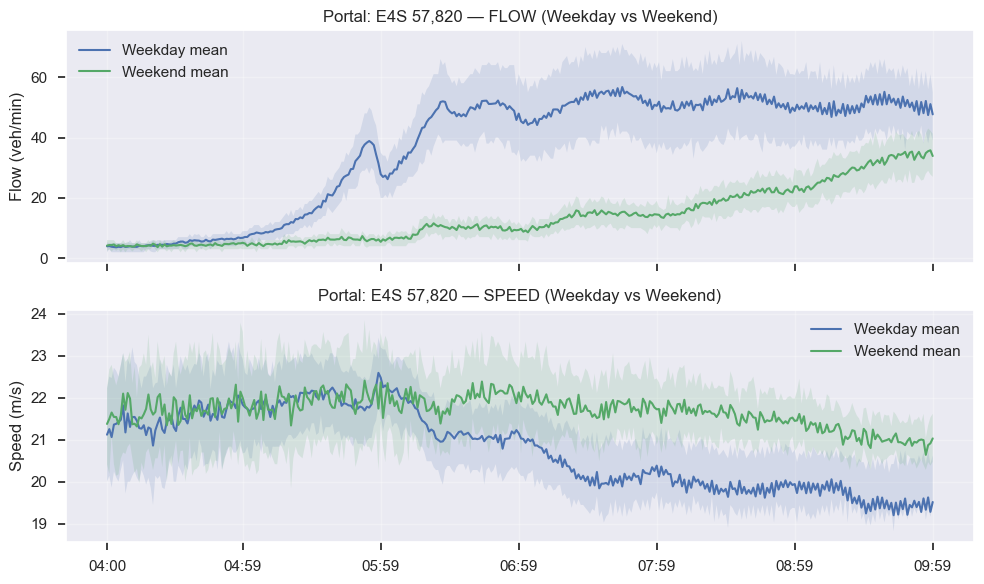

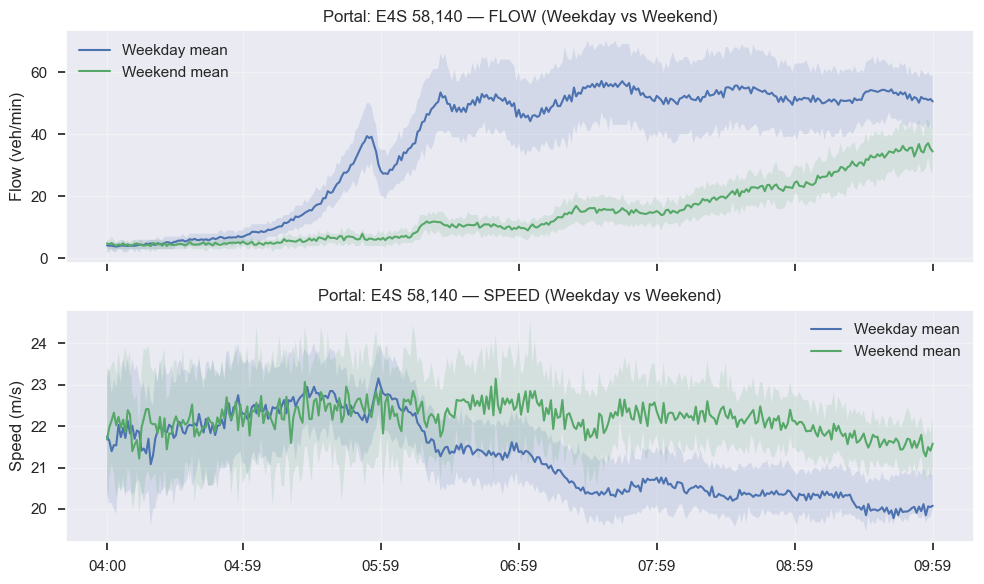

In [12]:

def summarize_profile_weektype(df_portal):
    out = []
    for wk, d0 in df_portal.groupby('is_weekend'):
        f = d0.groupby('minute_of_day')['FLOW_sum']
        s = d0.groupby('minute_of_day')['SPEED_mean']
        prof_flow = f.agg(mean='mean', p25=lambda x: x.quantile(0.25), p50='median', p75=lambda x: x.quantile(0.75))
        prof_speed = s.agg(mean='mean', p25=lambda x: x.quantile(0.25), p50='median', p75=lambda x: x.quantile(0.75))
        prof = pd.concat({'flow': prof_flow, 'speed': prof_speed}, axis=1).reset_index()
        prof['is_weekend'] = wk
        out.append(prof)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

profiles_wk = {}
for portal, d in g.groupby('PORTAL'):
    d_key = d[['PORTAL','date_only','minute_of_day']].drop_duplicates()
    key = d_key.merge(
        df[['PORTAL','date_only','minute_of_day','is_weekend']].drop_duplicates(),
        on=['PORTAL','date_only','minute_of_day'], how='left'
    )
    d2 = d.merge(key, on=['PORTAL','date_only','minute_of_day'], how='left')
    profiles_wk[portal] = summarize_profile_weektype(d2)

def plot_profile_wk(portal, profwk):
    if profwk.empty:
        return
    x = sorted(profwk['minute_of_day'].unique())
    xticks = np.linspace(min(x), max(x), 7, dtype=int)
    xtick_labels = [minute_to_label(v) for v in xticks]
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    for wk, d0 in profwk.groupby('is_weekend'):
        label = 'Weekend' if wk==1 else 'Weekday'
        axes[0].plot(d0['minute_of_day'], d0['flow']['mean'], label=f'{label} mean')
        axes[0].fill_between(d0['minute_of_day'], d0['flow']['p25'], d0['flow']['p75'], alpha=0.15)
        axes[1].plot(d0['minute_of_day'], d0['speed']['mean'], label=f'{label} mean')
        axes[1].fill_between(d0['minute_of_day'], d0['speed']['p25'], d0['speed']['p75'], alpha=0.15)
    axes[0].set_ylabel('Flow (veh/min)'); axes[0].set_title(f'Portal: {portal} — FLOW (Weekday vs Weekend)')
    axes[0].grid(alpha=0.3); axes[0].legend()
    axes[1].set_ylabel('Speed (m/s)');  axes[1].set_title(f'Portal: {portal} — SPEED (Weekday vs Weekend)')
    axes[1].grid(alpha=0.3); axes[1].legend()
    plt.xticks(xticks, xtick_labels, rotation=0)
    plt.tight_layout()
    savefig(f'portal_{portal.replace(" ","_")}_weekday_weekend.png')
    plt.show()

for portal, profwk in profiles_wk.items():
    plot_profile_wk(portal, profwk)


## 6. Observations (fill after running plots)
- Inner portals show earlier and steeper FLOW increase with speed drop.
- Weekday rush hour stronger; weekend lower volumes and higher speeds.
- Using portal-level per-minute aggregation fits modeling and feature design.
- 04:00–10:00 profiles highlight changes around 06:00 and target 07:30–08:30 window.


## 7. K-Means Clustering on Daily Morning Profiles

In [13]:

# Build daily morning profiles across all portals (04:00–10:00)
minutes = np.arange(4*60, 10*60)
day_min = (g.groupby(['date_only','minute_of_day'])
             .agg(flow=('FLOW_sum','sum'), speed=('SPEED_mean','mean'))
             .reset_index())

# Wide matrices: rows=days, cols=minute_of_day
speed_w = day_min.pivot(index='date_only', columns='minute_of_day', values='speed').reindex(columns=minutes)
flow_w  = day_min.pivot(index='date_only', columns='minute_of_day', values='flow').reindex(columns=minutes)

# Keep days with any data; interpolate along minutes
valid = (~speed_w.isna().all(axis=1)) & (~flow_w.isna().all(axis=1))
speed_w = speed_w.loc[valid].interpolate(axis=1, limit_direction='both')
flow_w  = flow_w.loc[valid].interpolate(axis=1, limit_direction='both')

print('Days for clustering:', speed_w.shape[0])
speed_w.head(2)


Days for clustering: 214


minute_of_day,240,241,242,243,244,245,246,247,248,249,...,590,591,592,593,594,595,596,597,598,599
date_only,,,,,,,,,,,,,,,,,,,,,
2021-06-01,21.169687,21.783333,21.097917,21.792292,23.394792,21.364688,21.515417,21.940833,22.327188,21.675937,...,18.253146,17.940500,17.469854,17.973188,18.493437,18.362458,18.857500,19.308042,19.172479,18.750771
2021-06-02,21.790000,21.689881,20.931562,21.792917,22.492396,21.886250,21.453125,20.958333,20.931667,21.869583,...,19.692021,19.519438,18.671854,18.655396,18.835729,19.101208,18.937167,18.848021,19.163333,19.327063


In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = np.hstack([speed_w.values, flow_w.values])
X = np.nan_to_num(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

labels_s = pd.Series(labels, index=speed_w.index, name='cluster').sort_index()
labels_s.head()


date_only
2021-06-01    3
2021-06-02    3
2021-06-03    3
2021-06-04    3
2021-06-05    1
Name: cluster, dtype: int32

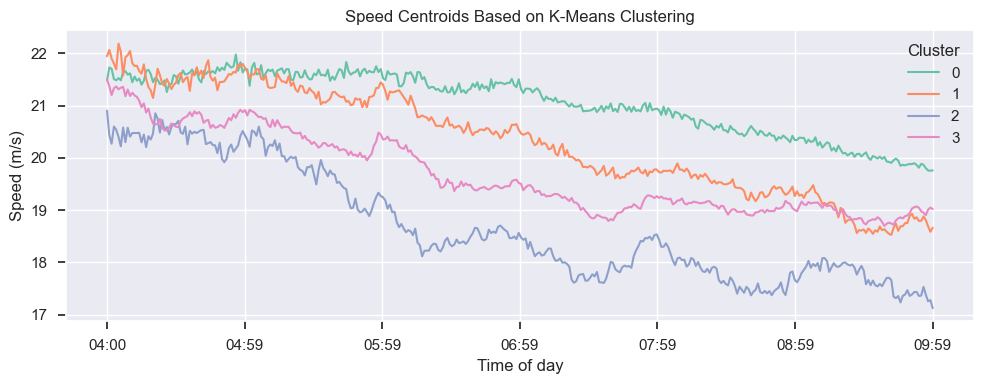

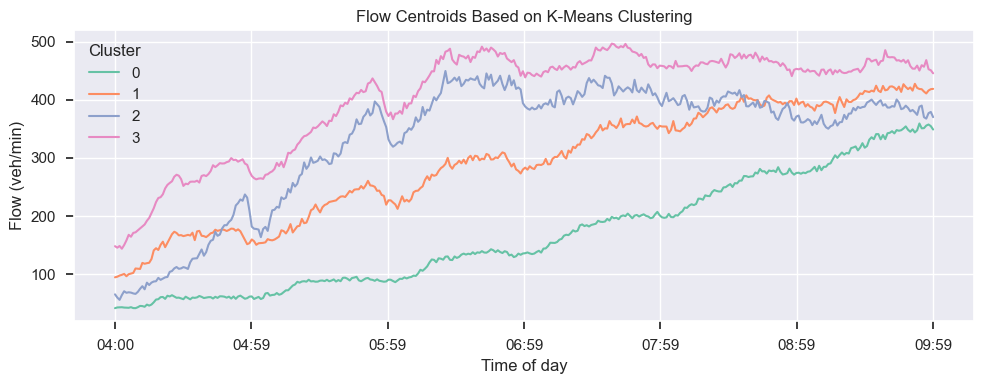

In [15]:

palette = sns.color_palette('Set2', n_clusters)

# Speed centroids
fig, ax = plt.subplots(1,1, figsize=(10,4))
for k in range(n_clusters):
    m = speed_w[labels_s.values==k].mean(axis=0)
    ax.plot(minutes, m, color=palette[k], label=str(k))
ax.set_xticks(np.linspace(minutes.min(), minutes.max(), 7))
ax.set_xticklabels([minute_to_label(int(v)) for v in ax.get_xticks()])
ax.set_xlabel('Time of day')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Speed Centroids Based on K-Means Clustering')
ax.legend(title='Cluster')
plt.tight_layout(); savefig('kmeans_speed_centroids.png'); plt.show()

# Flow centroids
fig, ax = plt.subplots(1,1, figsize=(10,4))
for k in range(n_clusters):
    m = flow_w[labels_s.values==k].mean(axis=0)
    ax.plot(minutes, m, color=palette[k], label=str(k))
ax.set_xticks(np.linspace(minutes.min(), minutes.max(), 7))
ax.set_xticklabels([minute_to_label(int(v)) for v in ax.get_xticks()])
ax.set_xlabel('Time of day')
ax.set_ylabel('Flow (veh/min)')
ax.set_title('Flow Centroids Based on K-Means Clustering')
ax.legend(title='Cluster')
plt.tight_layout(); savefig('kmeans_flow_centroids.png'); plt.show()


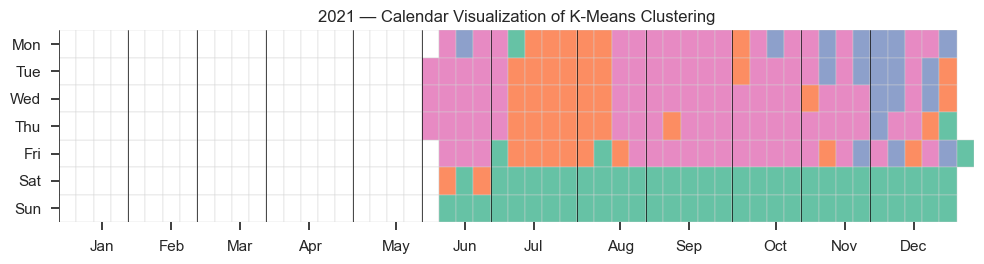

In [16]:

def plot_calendar(labels_s, title='Calendar Visualization of K-Means Clustering'):
    dates = pd.to_datetime(labels_s.index)
    year = int(pd.Timestamp(dates.min()).year)
    start = pd.Timestamp(year=year, month=1, day=1)
    end = pd.Timestamp(year=year, month=12, day=31)
    all_days = pd.date_range(start, end, freq='D')

    def week_index(d):
        return (d.timetuple().tm_yday - 1) // 7

    fig, ax = plt.subplots(1,1, figsize=(10,2.8))
    ax.set_xlim(-0.5, week_index(end.to_pydatetime().date()) + 0.5)
    ax.set_ylim(-0.5, 6.5)
    ax.set_yticks(range(7)); ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

    # Month separators + labels
    xticks = []
    xtlabs = []
    for m in range(1,13):
        mstart = pd.Timestamp(year=year, month=m, day=1)
        w = week_index(mstart.to_pydatetime().date())
        ax.axvline(w-0.5, color='k', lw=0.5)
        mid = pd.Timestamp(year=year, month=m, day=15)
        xticks.append(week_index(mid.to_pydatetime().date()))
        xtlabs.append(mid.strftime('%b'))
    ax.set_xticks(xticks); ax.set_xticklabels(xtlabs)

    pal = sns.color_palette('Set2', int(labels_s.max())+1)
    for d in all_days:
        w = week_index(d.to_pydatetime().date())
        wd = d.weekday()
        lab = labels_s.get(d.date(), np.nan)
        if pd.notna(lab):
            color = pal[int(lab)]
        else:
            color = 'white'
        ax.add_patch(plt.Rectangle((w-0.5, wd-0.5), 1, 1, color=color, ec='lightgrey', lw=0.3))
    ax.invert_yaxis()
    ax.set_title(f'{year} — {title}')
    ax.set_frame_on(False)
    plt.tight_layout(); savefig('kmeans_calendar.png'); plt.show()

plot_calendar(labels_s, title='Calendar Visualization of K-Means Clustering')


## 8. Deeper Diagnostics on Clusters

,days,median_peak_flow,median_low_speed,median_speed_4,median_speed_9,delta_speed_4_to_9
cluster,,,,,,
0,63,588.0,571.0,21.527708,20.372812,-1.154896
1,40,570.0,569.5,22.083140,19.517229,-2.565911
2,19,450.0,529.0,21.081458,17.608854,-3.472604
3,92,460.0,513.5,21.558385,19.051594,-2.506792


weekday
cluster


month
cluster


TypeError: no numeric data to plot

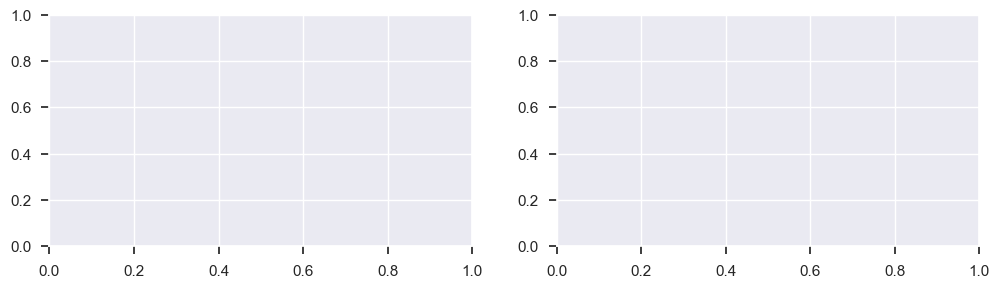

In [17]:

# Peak flow / lowest speed timing per day
peak_flow_time = flow_w.idxmax(axis=1)
low_speed_time = speed_w.idxmin(axis=1)

summary = (
    pd.DataFrame({
        'cluster': labels_s,
        'peak_flow_time': peak_flow_time,
        'low_speed_time': low_speed_time,
        'speed_at_4': speed_w[minutes.min()],
        'speed_at_9': speed_w[9*60] if 9*60 in speed_w.columns else np.nan,
    })
)
cluster_stats = summary.groupby('cluster').agg(
    days=('cluster','size'),
    median_peak_flow=('peak_flow_time', 'median'),
    median_low_speed=('low_speed_time', 'median'),
    median_speed_4=('speed_at_4','median'),
    median_speed_9=('speed_at_9','median')
)
cluster_stats['delta_speed_4_to_9'] = cluster_stats['median_speed_9'] - cluster_stats['median_speed_4']
display(cluster_stats)

# Day-of-week and monthly distribution
dow = pd.Series(speed_w.index).apply(lambda d: pd.Timestamp(d).weekday)
month = pd.Series(speed_w.index).apply(lambda d: pd.Timestamp(d).month)

dow_ct = pd.crosstab(labels_s, dow, rownames=['cluster'], colnames=['weekday'])
month_ct = pd.crosstab(labels_s, month, rownames=['cluster'], colnames=['month'])
display(dow_ct); display(month_ct)

fig, axes = plt.subplots(1,2, figsize=(12,3))
dow_ct.div(dow_ct.sum(1), axis=0).plot(kind='bar', stacked=True, ax=axes[0], colormap='Set3', legend=False)
axes[0].set_title('Weekday composition by cluster'); axes[0].set_ylim(0,1)
month_ct.div(month_ct.sum(1), axis=0).plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20', legend=False)
axes[1].set_title('Monthly composition by cluster'); axes[1].set_ylim(0,1)
plt.tight_layout(); savefig('kmeans_cluster_composition.png'); plt.show()

# Atypical days (distance to centroid)
dist = kmeans.transform(X_scaled).min(axis=1)
atypical = pd.Series(dist, index=speed_w.index, name='dist').sort_values(ascending=False)
print('Top 10 atypical days (by distance to centroid):')
display(atypical.head(10))


## 9. Discussion and Modeling Implications
- Clusters separate different morning regimes (timing of peak flow, pace of speed decay).
- Calendar view highlights temporal blocks (e.g., summer vs winter), useful for regime-aware training/validation splits.
- Centroids inform engineered targets or priors (e.g., expected speed drop window).
- Atypical days can be used to stress-test models and design robust imputations.